In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PyCo.SolidMechanics import PeriodicFFTElasticHalfSpace
from PyCo.Topography import Topography
from IPython.display import HTML
pnp = np

In [2]:
nx = 32
ny = 32
sx = 2 * np.pi
sy = 2 * np.pi
x = np.arange(nx).reshape(-1,1) /nx *sx
y = np.arange(ny).reshape(1,-1) /ny *sy



heights = np.cos(x) * np.cos(y) 
heights -= np.max(heights)

topography = Topography(heights,(sx, sy))

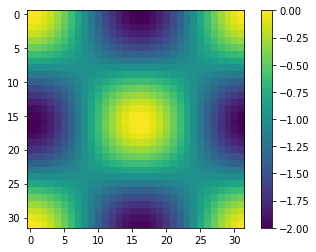

In [3]:
plt.colorbar(plt.imshow(heights))

original Basfaharan

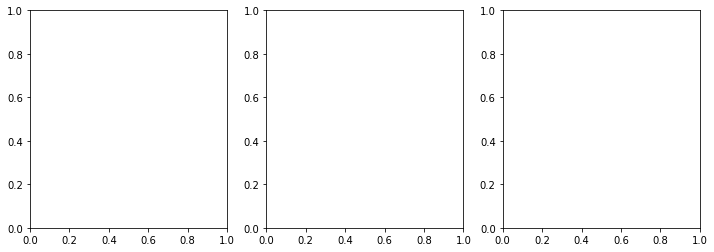

In [53]:

external_force= 2
sigma0 =1
h0  = 0.2
sigma0 *= topography.area_per_pt
nb_surface_pts = np.prod(topography.resolution)

substrate = PeriodicFFTElasticHalfSpace((nx,ny), young= 10, size=(sx,sy))

fig, (axpc, axg, axp) = plt.subplots(1,3, figsize=(12,4))   

MAXIT =200

def yield_iter(fig, sigma0, h0,external_force):
    
    
    
    # initial guess for p_r
    p_r = - np.ones_like(heights) * external_force / nb_surface_pts
    u_r = substrate.evaluate_disp(p_r)
    # initialisations
    delta = 0
    G_old = 1.0
    tau = 0.0
    t_r = np.zeros_like(u_r)
    g_r = u_r - heights

    axpc.set_title("pressure")
    axpc.axhline(0)
    axpc.axhline(sigma0)
    axpc.set_ylabel("pressure")
    lpc,  = axpc.plot((p_r * (p_r <= sigma0))[:, ny//2] / topography.area_per_pt, "+-r", label = "before balance")

    axgc = axpc.twinx()
    axgc.axhline(0)
    axgc.axhline(h0)
    axgc.set_ylabel("gap")
    lgc, = axgc.plot(g_r[:, ny//2], "--")

    #axgc.grid()
    caxp = plt.colorbar(axp.pcolormesh(p_r * (p_r <= sigma0) / topography.area_per_pt, rasterized = True), ax = axp).ax
    caxg = plt.colorbar(axg.pcolormesh(g_r , rasterized = True), ax = axg).ax
    axg.set_aspect(1)
    axp.set_aspect(1)
    axg.set_title("gap")
    
    it = 1
    max_pen = 1
    while max_pen > 1e-8 and it < MAXIT:
        axp.clear()
        axg.clear()
        c_r = p_r < sigma0 # = Ic in Bazrafshan

        A_cg = pnp.sum(c_r*1)
        print("A_cg {}".format(A_cg))
        # Compute deformation
        u_r = substrate.evaluate_disp((p_r<=sigma0) * p_r)
        # Compute gap
        g_r = u_r - heights

        if external_force is not None:
            offset = 0
            if A_cg > 0:
                offset = pnp.sum(g_r[c_r]) / A_cg
        g_r -= offset

        print("offset: {}".format(offset))


        lgc.set_ydata(g_r[:, ny//2])
        plt.colorbar(axg.pcolormesh(g_r , rasterized = True), cax = caxg)

        ########### Search direction
        # Compute G = sum(g*g) (over contact area only)
        G = pnp.sum(c_r*g_r*g_r)

        if delta > 0 and G_old > 0: # CG step
            t_r = c_r*(g_r + delta*(G/G_old)*t_r)
        else: # steepest descend step (CG restart)
            t_r = c_r*g_r

        r_r = substrate.evaluate_disp(t_r)
        #bazrafshan
        #r_r -= pnp.sum(r_r[c_r]) / A_cg

        ########## Step size
        tau = 0.0
        if A_cg > 0:
            # tau = -sum(g*t)/sum(r*t) where sum is only over contact region
            x = -pnp.sum(c_r*r_r*t_r)
            if x > 0.0:
                tau = pnp.sum(c_r*g_r*t_r)/x
            else:
                print("x < 0")
                G = 0.0

        # Compute root-mean square penetration, max penetration and max force
        # difference between the steps
        if A_cg > 0:
            rms_pen = np.sqrt(G/A_cg)
        else:
            rms_pen = np.sqrt(G)
        max_pen = max(0.0, pnp.max(-g_r))
        print("rms_pen {}".format(rms_pen))
        print("max_pen {}".format(max_pen))        
        ########## Do step
        print("tau {}".format(tau))
        p_r += tau*c_r*t_r

        ######### Projection on feasible set
        p_r[p_r>sigma0] = sigma0
        #p_r[np.logical_and(g_r>0, p_r>=0)] = sigma0 # not in bas, but I suggest to add new points to sigma0
        ######### Remove points with gap greater then h0 from interacting points
        outside_mask = np.logical_and(g_r > h0, p_r >= 0) # bas
        #outside_mask = g_r > h0
        p_r[outside_mask] = 1000 * sigma0

        ######### Overlap Area: points to be added to the part where the gap is minimized
        overlap_mask = np.logical_and(g_r < 0, p_r > 0) # bazrafshan
        #overlap_mask = np.logical_and(g_r < 0, p_r >=sigma0) 
        # points with p_r < sigma 0 are already in the contact area

        N_overlap = pnp.sum(overlap_mask*1.)
        print("N_overlap {}".format(N_overlap))
        if N_overlap > 0:
            delta = 0. # this will restart the conjugate gradient with a steepest descent
            p_r[overlap_mask] += tau * g_r[overlap_mask]
        else: 
            delta = 1.

        lpc.set_ydata((p_r * (p_r <= sigma0))[:, ny//2] / topography.area_per_pt)
        ######### Impose force balance
        print("computed_force before balance {}".format(- pnp.sum(p_r * (p_r <= sigma0) )))
        if external_force is not None:
            contact_mask = p_r < sigma0 # not including the Dugdale zone, because there the pressure should not change
            N_contact= pnp.sum(contact_mask)

            contact_psum = pnp.sum(p_r[contact_mask])
            print(contact_psum)
            N_Dugdale = pnp.sum(p_r == sigma0)
            print("N_Dugdale: {}".format(N_Dugdale))
            if contact_psum != 0:
                fact = ( ( - external_force - sigma0 * N_Dugdale) + N_contact * sigma0) \
                       / (contact_psum + N_contact * sigma0)
                p_r[contact_mask] = fact * (p_r[contact_mask]  + sigma0) - sigma0
            else:
                # add constant pressure everywhere
                p_r += (-external_force - sigma0 * N_Dugdale)/nb_surface_pts*np.ones_like(p_r)
                #p_r[pad_mask] = 0.0
        print("computed_force {}".format(- pnp.sum(p_r * (p_r <= sigma0) )))


        plt.colorbar(axp.pcolormesh(p_r * (p_r <= sigma0) / topography.area_per_pt, rasterized = True), cax = caxp)

        #axpc.plot((p_r * (p_r <= sigma0))[:, ny//2] / topography.area_per_pt, "+", label = "after balance")
        #axpc.legend()

        print("max_pen {}".format(max_pen))

        #fig, ax = plt.subplots()
        #plt.colorbar(ax.pcolormesh((np.ma.masked_array(p_r, mask = 1 - (g_r > 0 )* (g_r<=h0) * (p_r != sigma0) ))))
        #ax.set_aspect(1)
        #ax.set_title("regions where 0 < g_r <= h0 but pressure is not sigma0")
        #assert (p_r[(g_r > 0 )* (g_r<=h0)] == sigma0).all()

        it +=1
        fig.canvas.draw()
        yield it
#
#ani = FuncAnimation(fig, lambda i : gen.__next__(), frames=range(MAXIT), init_func= gen.__next__)


#HTML(ani.to_html5_video())

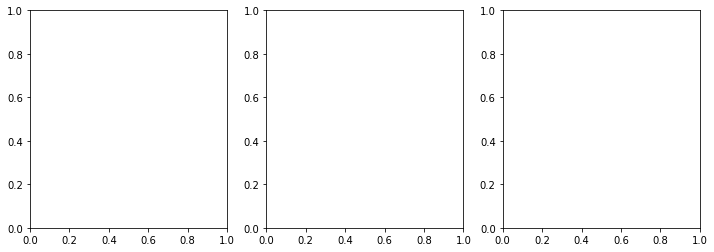

In [56]:
fig, (axpc, axg, axp) = plt.subplots(1,3, figsize=(12,4))  
gen=yield_iter(fig, sigma0, h0,external_force)

A_cg 90
offset: 0.26068549393505874
rms_pen 5.18178252592226e-06
max_pen 1.2905463537327133e-05
tau 1.3473554108382524
N_overlap 0.0
computed_force before balance 1.999999999999997
-5.392676512874464
N_Dugdale: 88
computed_force 1.9999999999999996
max_pen 1.2905463537327133e-05


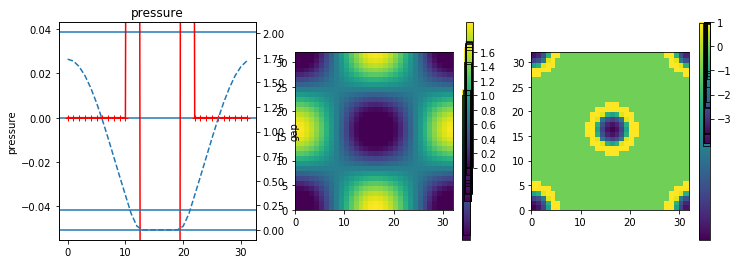

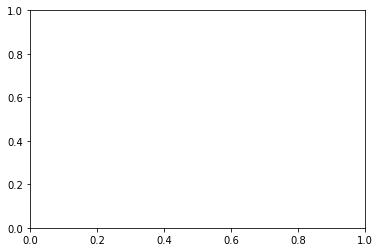

In [77]:
next(gen)
fig

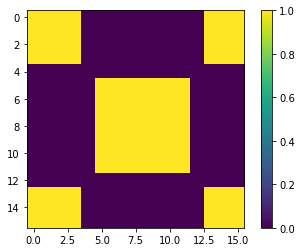

In [162]:
plt.colorbar(plt.imshow(c_r*1.))